In [1]:
# !pip install pytorch_tabnet
!pip install catboost
!pip install lightgbm
# !pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.8 MB/s eta 0:00:00


In [8]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   

from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier

# import optuna
# from optuna.samplers import TPESampler
# from optuna import Trial

from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정
seed_num=37

from google.colab import drive # GoogleDrive mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 

# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 3) MinMaxscaling: only `X_???` values (continuous)
from sklearn.preprocessing import StandardScaler
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=37)

# 2.catBoost classifier 

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(train_x, train_y,
                                                   test_size=0.3,
                                                   random_state=37)
     

def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     
# hyper-parameter tuning with OPTUNA  
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=316)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

In [ ]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

In [ ]:
import pickle
pickle.dump(model, open("catboost_model.pkl", "wb"))
     

optuna.visualization.plot_optimization_history(study)
     

optuna.visualization.plot_parallel_coordinate(study)
     

# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "iterations",
        "learning_rate",
        "depth",
        "l2_leaf_reg",
        "bootstrap_type",
        "random_strength",
        "bagging_temperature",
        "od_type",
        "od_wait"
        ],
)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
preds = model.predict(test_x)
     

preds

In [ ]:
submit = pd.read_csv('C:/Users/user/OneDrive/open/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('C:/Users/user/OneDrive/open/smartFactory_submission_MLP.csv', index=False)
# submit.to_csv('smartFactory_submission.csv', index=False)

In [13]:
import seaborn as sns 

# 3.VotingClassifier

In [84]:
GBC_param= {'n_estimators': 1400, 'learning_rate': 0.007793231258605556, 'max_depth': 6, 'subsample': 0.8, 'max_features': 'sqrt'}
CB_param= {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, 'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', 'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, 'od_type': 'IncToDec', 'od_wait': 42}

models = [
    CatBoostClassifier(
        # objective='MultiClass', task_type='GPU', one_hot_max_size=2, iterations=4000, learning_rate=0.05, 
        verbose=False, random_seed=seed_num, 
        **CB_param
                                   ),
    # LGBMClassifier(objective='multiclass', random_state=seed_num),
    XGBClassifier(random_state=seed_num),
    GradientBoostingClassifier(random_state=seed_num),    
    # RidgeClassifierCV(),
]
[x.fit(train_x, train_y) for x in models]


 XGBClassifier(objective='multi:softprob', random_state=37),
 GradientBoostingClassifier(random_state=37)]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

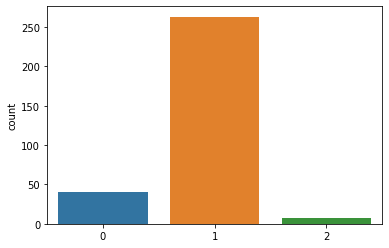

In [85]:
def predict(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = predict(models, test_x, 'hard',  
                [2,1,2] )

sns.countplot(x=preds);    
preds


1    263
0     40
2      7
Name: Y_Class, dtype: int64

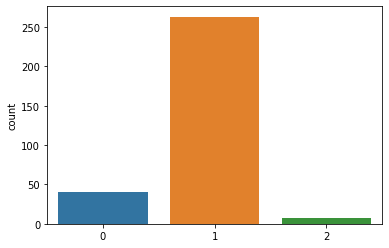

In [86]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CparamXG212-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);
submit.Y_Class.value_counts()

1    265
0     37
2      8
Name: Y_Class, dtype: int64

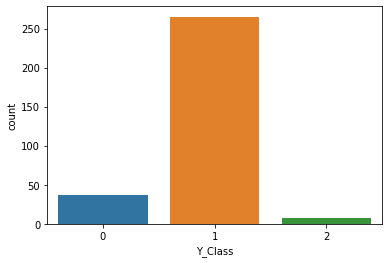

In [93]:
aaa = pd.read_csv('CXG212(1)-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

In [99]:
# 148  1 2 
# 163  2
# 166  2 
# 295  1 0 
# 32/495

0.06464646464646465

1    253
0     42
2     15
Name: Y_Class, dtype: int64

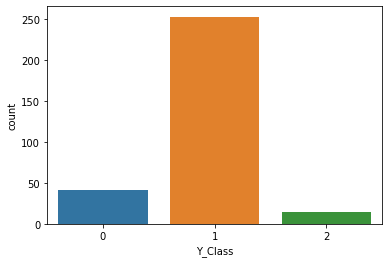

In [95]:
aaa = pd.read_csv('/content/drive/MyDrive/GBCminmax-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    260
0     43
2      7
Name: Y_Class, dtype: int64

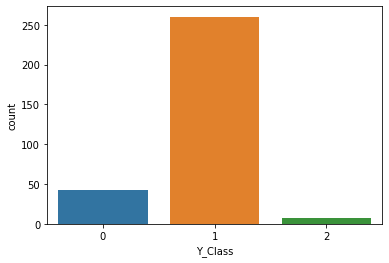

In [63]:
aaa = pd.read_csv('/content/drive/MyDrive/GBCoptuna-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    267
0     37
2      6
Name: Y_Class, dtype: int64

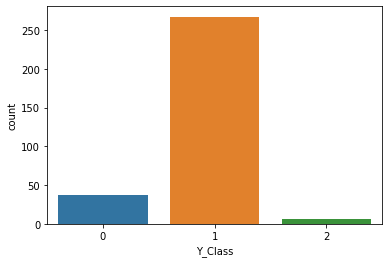

In [55]:
aaa = pd.read_csv('/content/drive/MyDrive/voting.catB_GBC-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    274
0     29
2      7
Name: Y_Class, dtype: int64

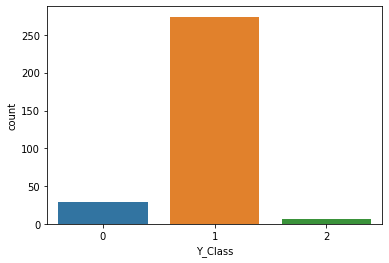

In [54]:
sdf = pd.read_csv('/content/drive/MyDrive/smartFactory_submission18.csv')
sns.countplot(x=sdf.Y_Class);
sdf.Y_Class.value_counts()

## 3.1 StackingClassifier

In [6]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

models = [
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    XGBClassifier(random_state=seed_num),
    GradientBoostingClassifier(random_state=seed_num),   # GBC: no tuning is the best 
    RidgeClassifierCV(),
]

# [x.fit(train_x, train_y) for x in models]   

In [ ]:
# find weights for each model 
model_list = ['catboost', 'lgbm', 'xgb', 'gradient', 'ridge']
num=0

for model in models: 
  preds = model.fit(train_x, train_y).predict(test_x)
  if num == 0:  # catboostclassifier 
    preds= preds.reshape(1,test_x.shape[0])  # test_x.shape[0] = number of columns 
    preds = list(preds[0])
    num+=1
  else: 
    preds.reshape(1,test_x.shape[0])
    preds=list(preds)
  
  globals()[f'preds_{model_list[num]}'] = preds   # set variable name for each model prediction results  
  
  print(model,  globals()[f'preds_{model_list[num]}'])   

<catboost.core.CatBoostClassifier object at 0x7f17b43af610> [1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
LGBMClass

In [ ]:
preds_catb = [1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_lgbm = [1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_xgb = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_bagging = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1]
preds_gradient = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
preds_ridge = [1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CXG212-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);

NameError: ignored

In [9]:
stack = StackingClassifier(
    estimators=models,
    final_estimator=LogisticRegression(),  
    cv=5,
    n_jobs=4,
    passthrough=True
)

# use X_test as validation set      
stack.fit(train_x, train_y)

train_stack = np.concatenate(
    [model.predict_proba(train_x) for model in models], axis=1)
val_stack = np.concatenate(
    [model.predict_proba(X_test) for model in models], axis=1)

# meta model training
meta_model = LogisticRegression().fit(train_stack, train_y)
preds = meta_model.predict(val_stack)



TypeError: ignored

In [ ]:
# object fit train_x, train_y, random_state=37  

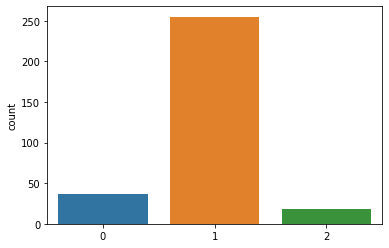

In [ ]:
seed_num=37

GBC_model = GradientBoostingClassifier(random_state=37
              ).fit(train_x, train_y)

preds = GBC_model.predict(test_x)
sns.countplot(x=preds);

# 4.Sequential MLP

Epoch 1/5
6/6 [==============================] - 1s 42ms/step - loss: 4.5826 - accuracy: 0.5837 - val_loss: 4.8250 - val_accuracy: 0.5917
Epoch 2/5
6/6 [==============================] - 0s 13ms/step - loss: 2.7988 - accuracy: 0.5962 - val_loss: 2.6763 - val_accuracy: 0.6833
Epoch 3/5
6/6 [==============================] - 0s 13ms/step - loss: 2.1086 - accuracy: 0.6360 - val_loss: 2.2737 - val_accuracy: 0.6417
Epoch 4/5
6/6 [==============================] - 0s 12ms/step - loss: 1.8722 - accuracy: 0.6569 - val_loss: 1.6281 - val_accuracy: 0.5500
Epoch 5/5
10/10 [==============================] - 0s 2ms/step


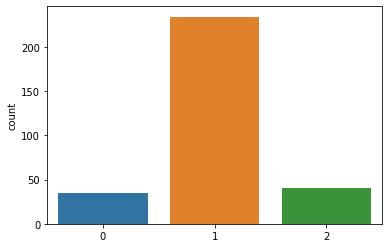

In [ ]:
model = Sequential([
    # Input layer: ReLU (decide input size according to dimension)
    Dense(512, activation='relu', input_shape=(train_x.shape[-1],)),    
    # BatchNormalization(), 
    Dropout(0.3), 

    # Output layer: softmax 
    Dense(3, activation='softmax')  

    ])
from keras import optimizers, metrics, callbacks
import seaborn as sns 
model.compile(optimizer = optimizers.Adam(1e-3),  # default learning rate=1e-3 
            loss='sparse_categorical_crossentropy',  # tow or more label classes (`Y_Class`: 0,1,2)
            metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5,
                    batch_size=80,  # batch size: 2^x && half of data size(598/2) 
                    validation_split=0.2,
                    )   

preds = model.predict(test_x)
a=[]
for i in preds: 
    i = list(i)
    a.append(i.index(max(i)))
sns.countplot(x=a);

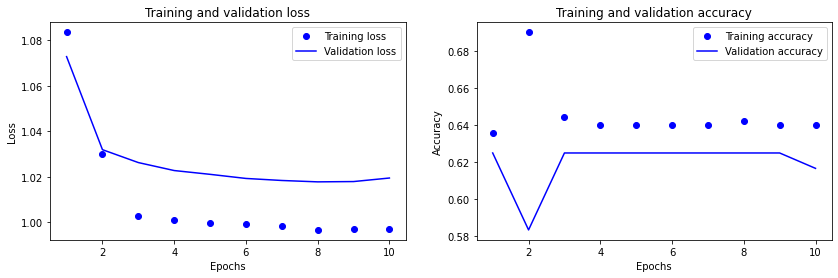

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(1,2,figsize=(14,4))
ax= axes.flatten()
a, b = ax[0], ax[1]

a.plot(epochs, history.history["loss"], "bo", label="Training loss")
a.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
a.set_title("Training and validation loss")
a.set_xlabel("Epochs")
a.set_ylabel("Loss")
a.legend()   

b.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
b.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
b.set_title("Training and validation accuracy")
b.set_xlabel("Epochs")
b.set_ylabel("Accuracy")
b.legend();

# 5.Specific feature 

Done.


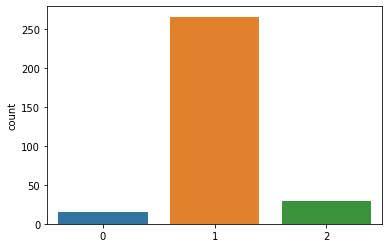

In [75]:
x=train_x.loc[:,['X_1834','X_1945','X_256','X_248','X_258','X_373','X_131','X_2841']]
y=train_y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as ms

model = GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')
y_pred = model.predict(X_test)
# test_x = test_x.drop(columns=['LINE', 'PRODUCT_CODE'])

test_x=test_x.loc[:,['X_1834','X_1945','X_256','X_248','X_258','X_373','X_131','X_2841']]
preds = model.predict(test_x)
sns.countplot(x=preds); 
# preds.value_counts()

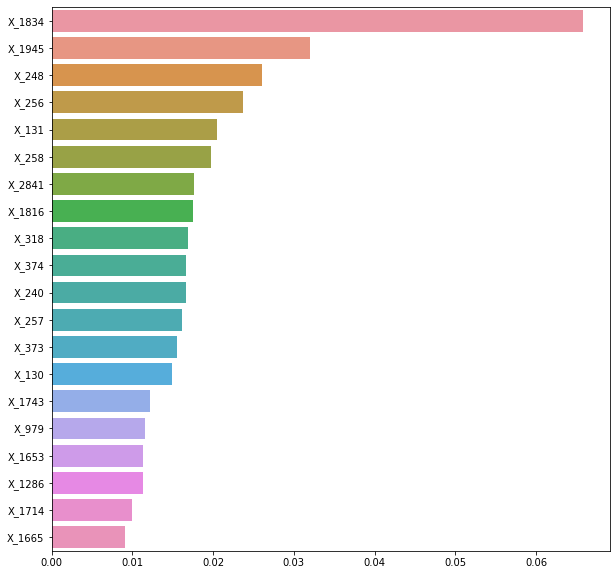

In [80]:
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
rf_run = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
rf_run.fit(X_train, y_train)
ftr_importances_values = rf_run.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

# THE END